In [19]:
from a3_utils import *
from UZ_utils import *
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
from copy import deepcopy
from ipywidgets import interact, FloatSlider, Layout, fixed

In [20]:
def gauss(sigma):
    center = int(np.ceil(3.0 * sigma))
    x = np.arange(-center, center + 1)
    kernel = np.exp(-(x**2) / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    kernel /= np.sum(kernel)
    return kernel

def euclidean(H1, H2):
    return np.sqrt(np.sum(np.square(H1 - H2)))

def chi_square(H1, H2, epsilon = 1e-10):
    return np.sum(np.square(H1 - H2) / (H1 + H2 + epsilon)) / 2

def intersection(H1, H2):
    return 1 - np.sum(np.minimum(H1, H2))

def hellinger(H1, H2):
    return np.sqrt(np.sum(np.square(np.sqrt(H1) - np.sqrt(H2))) / 2)

def display_similar(metric, ref_hist, dataset_hists, n_bins):
    hists_distance = [(hist, img, name, metric(hist, ref_hist), i) for i, (hist, img, name) in enumerate(dataset_hists)]
    hists_sorted = sorted(hists_distance, key=lambda a: a[3])
    fig = plt.figure(figsize=(20,5))
    for i, (H, img, name, distance, index) in enumerate(hists_sorted[:6]):
        ax = fig.add_subplot(2, 6, i+1, title=f"{name}: {distance:.3f}")
        ax.imshow(img)
        ax = fig.add_subplot(2, 6, 6+i+1)
        ax.bar(range(n_bins**3), H.transpose().flatten(), width=10)

    return hists_distance, hists_sorted

# Exercise 1: Image derivatives

### (a) Derive the equations used to compute first and second derivative

$$
I_x(x, y) = \frac{\delta}{\delta x} \left[ g(x) * g(y) * I(x, y) \right] = \frac{d}{dx} g(x) * \left[ g(y) * I(x, y) \right]
$$

$$
I_y(x, y) = \frac{\delta}{\delta y} \left[ g(x) * g(y) * I(x, y) \right] = \frac{d}{dy} g(y) * \left[ g(x) * I(x, y) \right]
$$

$$
I_{xx}(x, y) = \frac{\delta}{\delta x} \left[ g(x) * g(y) * I_x(x, y) \right] = \frac{d}{dx} g(x) * \left[ g(y) * I_x(x, y) \right]
$$

$$
I_{yy}(x, y) = \frac{\delta}{\delta y} \left[ g(x) * g(y) * I_y(x, y) \right] = \frac{d}{dy} g(y) * \left[ g(x) * I_y(x, y) \right]
$$

$$
I_{xy}(x, y) = \frac{\delta}{\delta y} \left[ g(x) * g(y) * I_x(x, y) \right] = \frac{d}{dy} g(y) * \left[ g(x) * I_x(x, y) \right]
$$


### (b) Implement a function that computes the derivative of a 1-D Gaussian kerne

In [21]:
def gaussdx(sigma):
    center = int(np.ceil(3.0 * sigma))
    x = np.arange(-center, center + 1)
    kernel =  -x * np.exp(-(x**2) / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * (sigma ** 3))
    kernel /= np.sum(np.abs(kernel))
    return kernel

### (c) The properties of the filter can be analyzed by using an impulse response function

In [ ]:
def visualize_gaussdx(sigma):
    impulse = np.zeros((50, 50))
    impulse[25, 25] = 1

    G = gauss(sigma).reshape((1, -1))
    Gt = G.reshape((-1, 1))

    D = gaussdx(sigma).reshape((1, -1))
    Dt = D.reshape((-1, 1))

    impulse_G = cv2.filter2D(impulse, -1, np.flip(G))
    impulse_D = cv2.filter2D(impulse, -1, np.flip(D))
    impulse_Gt = cv2.filter2D(impulse, -1, np.flip(Gt))
    impulse_Dt = cv2.filter2D(impulse, -1, np.flip(Dt))

    plt.figure(figsize=(9, 6))

    plt.subplot(2, 3, 1)
    plt.imshow(impulse, 'gray')
    plt.title('Impulse')

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.filter2D(impulse_G, -1, np.flip(Dt)), 'gray')
    plt.title('G, Dt')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.filter2D(impulse_D, -1, np.flip(Gt)), 'gray')
    plt.title('D, Gt')

    plt.subplot(2, 3, 4)
    plt.imshow(cv2.filter2D(impulse_G, -1, np.flip(Gt)), 'gray')
    plt.title('G, Gt')

    plt.subplot(2, 3, 5)
    plt.imshow(cv2.filter2D(impulse_Gt, -1, np.flip(D)), 'gray')
    plt.title('Gt, D')

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.filter2D(impulse_Dt, -1, np.flip(G)), 'gray')
    plt.title('Dt, G')

    plt.tight_layout()
    plt.show()

interact(visualize_gaussdx, sigma=FloatSlider(value=4, min=0.1, max=10, step=0.1, description="Sigma"));


interactive(children=(FloatSlider(value=4.0, description='Sigma', max=10.0, min=0.1), Output()), _dom_classes=…

### (d) Implement a function that returns partial derivatives of a given image

In [23]:
def partial_derivatives(I, sigma):
    G = gauss(sigma).reshape(1, -1)
    Gt = G.reshape(-1, 1)

    Gdx = gaussdx(sigma).reshape(1, -1)
    Gdxt = Gdx.reshape(-1, 1)

    Ix = cv2.filter2D(cv2.filter2D(I, -1, Gt), -1, Gdx)
    Iy = cv2.filter2D(cv2.filter2D(I, -1, G), -1, Gdxt)

    return Ix, Iy

def partial_second_derivatives(I, sigma):
    G = gauss(sigma).reshape(1, -1)
    Gt = G.reshape(-1, 1)

    Gdx = gaussdx(sigma).reshape(1, -1)
    Gdxt = Gdx.reshape(-1, 1)

    Ix, Iy = partial_derivatives(I, sigma)

    Ixx = cv2.filter2D(cv2.filter2D(Ix, -1, Gt), -1, Gdx)
    Ixy = cv2.filter2D(cv2.filter2D(Ix, -1, Gdxt), -1, G)
    Iyy = cv2.filter2D(cv2.filter2D(Iy, -1, G), -1, Gdxt)

    return Ixx, Ixy, Iyy

def gradient_magnitude(grayI, sigma=3.0):
    Ix, Iy = partial_derivatives(grayI, sigma)

    I_mag = np.sqrt(np.square(Ix) + np.square(Iy))
    I_dir = np.arctan2(Iy, Ix)

    return I_mag, I_dir

In [ ]:
def visualize_derivatives(image, sigma):
    I_x, I_y = partial_derivatives(image, sigma)
    I_xx, I_xy, I_yy = partial_second_derivatives(image, sigma)
    I_mag, I_dir = gradient_magnitude(image, sigma)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 4, 1)
    plt.imshow(image, 'gray')
    plt.title('Original')

    plt.subplot(2, 4, 2)
    plt.imshow(I_x, 'gray')
    plt.title('I_x')

    plt.subplot(2, 4, 3)
    plt.imshow(I_y, 'gray')
    plt.title('I_y')

    plt.subplot(2, 4, 4)
    plt.imshow(I_mag, 'gray')
    plt.title('I_mag')

    plt.subplot(2, 4, 5)
    plt.imshow(I_xx, 'gray')
    plt.title('I_xx')

    plt.subplot(2, 4, 6)
    plt.imshow(I_xy, 'gray')
    plt.title('I_xy')

    plt.subplot(2, 4, 7)
    plt.imshow(I_yy, 'gray')
    plt.title('I_yy')

    plt.subplot(2, 4, 8)
    plt.imshow(I_dir, 'gray')
    plt.title('I_dir')

    plt.tight_layout()
    plt.show()


museum = imread_gray('images/museum.jpg')
interact(visualize_derivatives, image=fixed(museum), sigma=FloatSlider(value=2.0, min=0.1, max=10, step=0.1, description="Sigma"));

interactive(children=(FloatSlider(value=2.0, description='Sigma', max=10.0, min=0.1), Output()), _dom_classes=…

### (e) Gradient image retrieval

In [25]:
def compute_gradient_histogram(image, sigma=10.0, n_bins=8, grid_size=8):
    I_mag, I_dir = gradient_magnitude(image, sigma)

    # image to (8x8) grid
    h, w = image.shape
    cell_size_x = w // grid_size
    cell_size_y = h // grid_size
    x_indices = (np.arange(w) // cell_size_x).clip(0, grid_size - 1)
    y_indices = (np.arange(h) // cell_size_y).clip(0, grid_size - 1)
    grid_x, grid_y = np.meshgrid(x_indices, y_indices)

    # gradient direction bins
    angle_bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    bin_indices = np.digitize(I_dir, angle_bins) - 1
    bin_indices[bin_indices == n_bins] = n_bins - 1

    # to 1D arrays for vector proccessing
    flat_bins = bin_indices.ravel()
    flat_mags = I_mag.ravel()
    flat_grid_x = grid_x.ravel()
    flat_grid_y = grid_y.ravel()

    # to 3D histogram
    histograms = np.zeros((grid_size, grid_size, n_bins), dtype=np.float32)
    np.add.at(
        histograms, 
        (flat_grid_y, flat_grid_x, flat_bins), 
        flat_mags
    )

    histograms /= np.sum(histograms)

    return histograms.flatten()

def compute_gradient_histograms(directory, n_bins=8, grid_size=8):
    histograms = []
    for filename in os.listdir(directory):
        img = imread(os.path.join(directory, filename))
        gradient_hist = compute_gradient_histogram(to_grayscale(img), n_bins, grid_size)
        histograms.append((gradient_hist, img, filename))
    return histograms

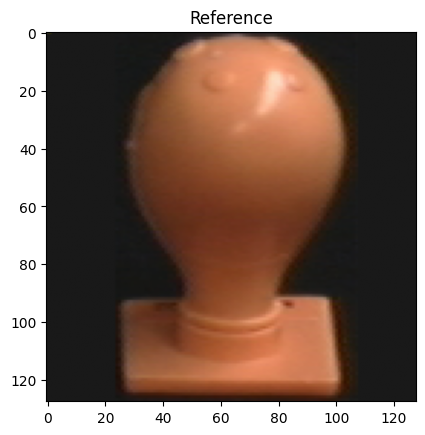

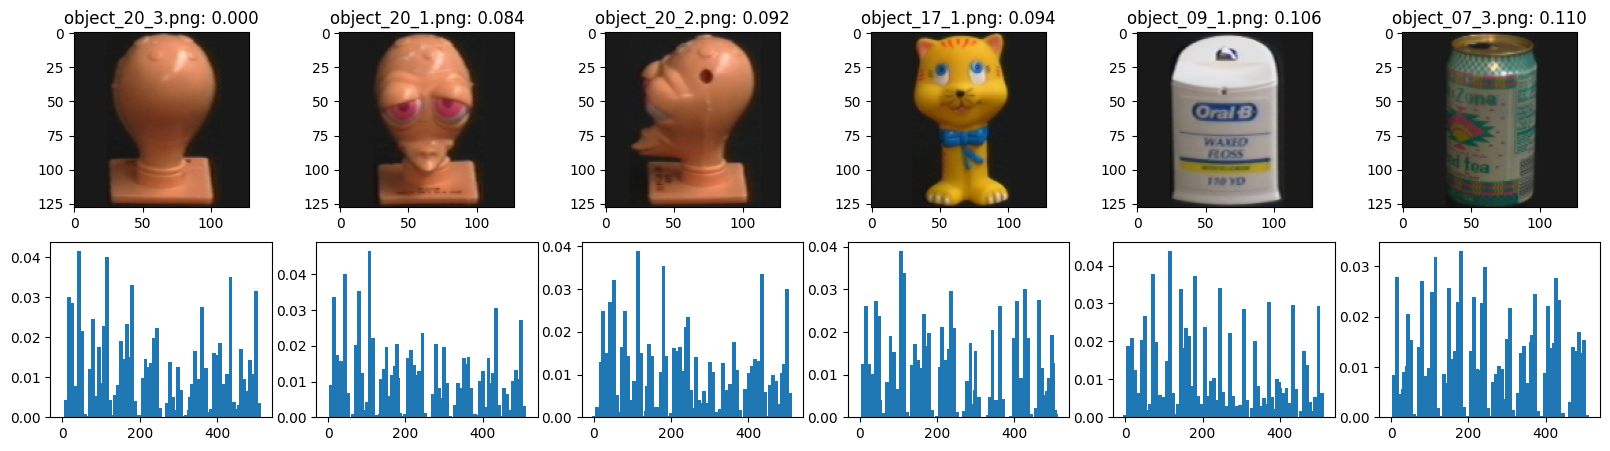

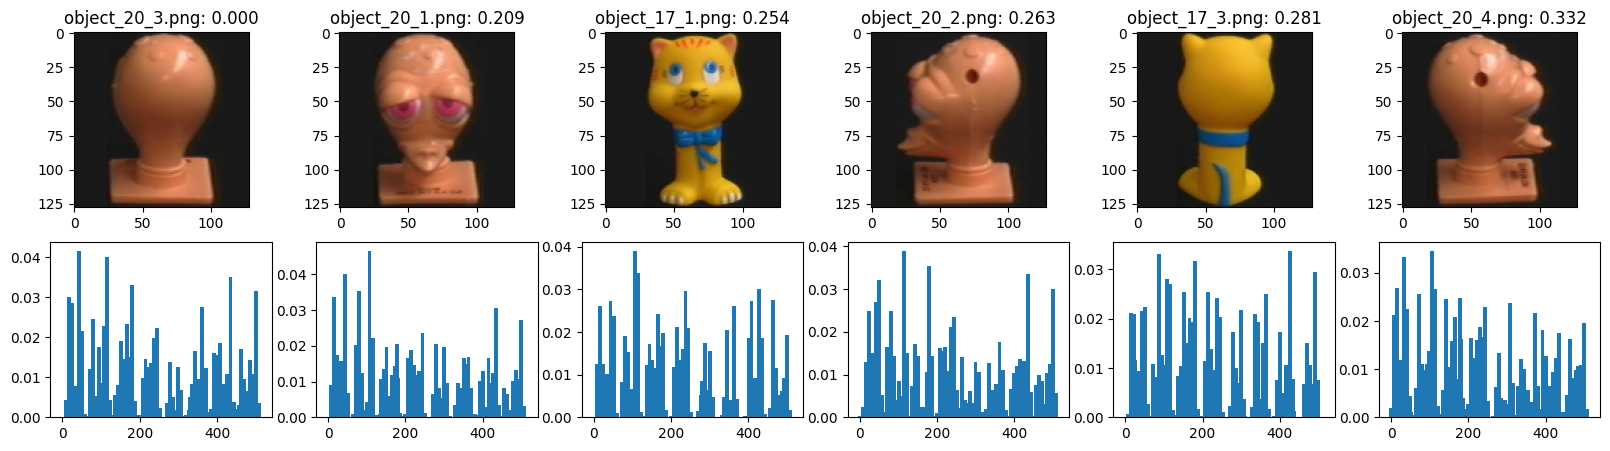

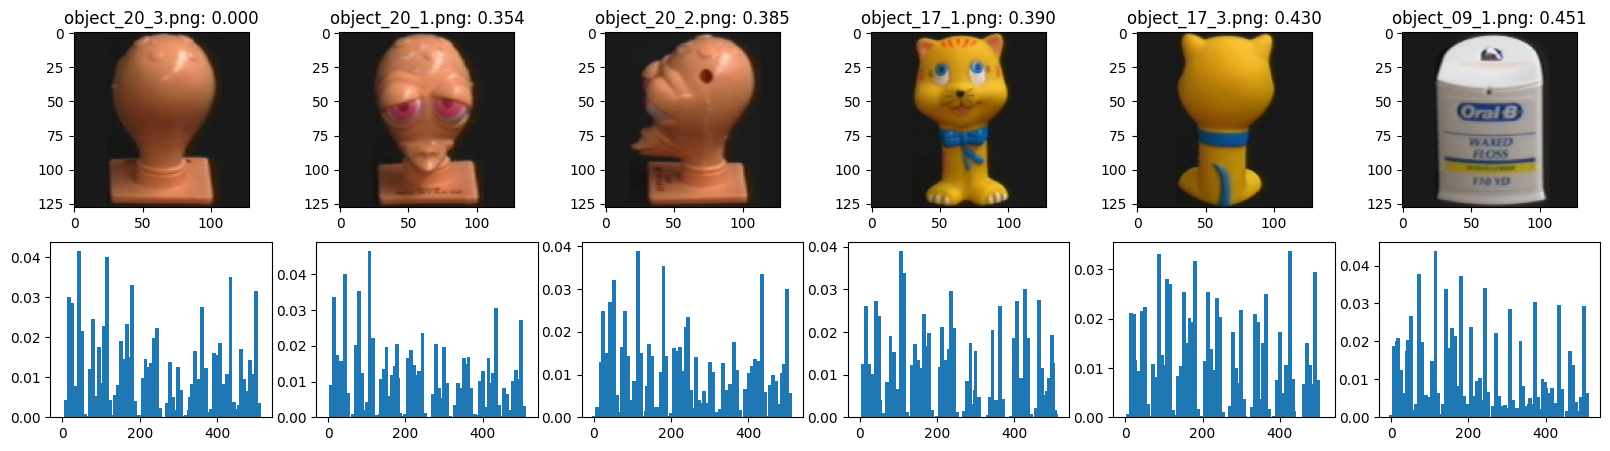

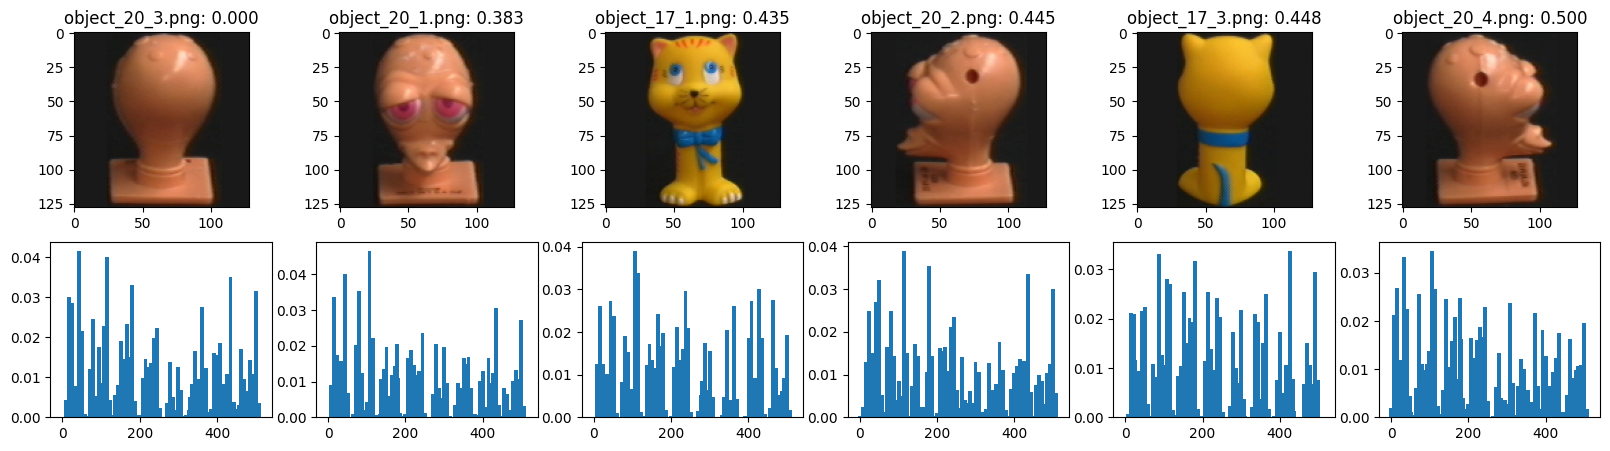

In [ ]:
n_bins = 8
grid_size = 8
ref_img = imread('dataset/object_20_3.png')
ref_hist = compute_gradient_histogram(to_grayscale(ref_img), n_bins, grid_size)

dataset_hists = compute_gradient_histograms('dataset', n_bins, grid_size)

imshow(ref_img, title="Reference")
euc_dist, euc_sort_dist = display_similar(euclidean, ref_hist, dataset_hists, n_bins)
chi_dist, chi_sort_dist = display_similar(chi_square, ref_hist, dataset_hists, n_bins)
inte_dist, inte_sort_dist = display_similar(intersection, ref_hist, dataset_hists, n_bins)
hel_dist, hel_sort_dist = display_similar(hellinger, ref_hist, dataset_hists, n_bins)


# Exercise 2: Edges in images

### (a) Create a function findedges

In [43]:
def findedges(I, sigma, theta):
    I_mag, I_dir = gradient_magnitude(to_grayscale(I), sigma)
    return np.where(I_mag >= theta, 1, 0)

In [49]:
def visualize_findedges(I, sigma, theta):
    edges = findedges(I, sigma, theta)

    plt.figure(figsize=(8, 4))

    plt.subplot(2, 3, 1)
    plt.imshow(I)
    plt.title('Original')

    plt.subplot(2, 3, 2)
    plt.imshow(edges)
    plt.title('Edges')

    plt.tight_layout()
    plt.show()

museum = imread('images/museum.jpg')
interact(visualize_findedges, I=fixed(museum), sigma=FloatSlider(value=2.5, min=0.1, max=10, step=0.1, description="Sigma"), theta=FloatSlider(value=0.09, min=0.01, max=0.3, step=0.005, description="Theta"));


interactive(children=(FloatSlider(value=2.5, description='Sigma', max=10.0, min=0.1), FloatSlider(value=0.09, …

### (b) Implement non-maxima suppression

In [ ]:
def non_maxima_suppression_findedges(I_mag, I_dir):
    """
    Perform fully vectorized non-maximum suppression.
    
    Parameters:
        I_mag: 2D array of gradient magnitudes.
        I_dir: 2D array of gradient orientations in radians.
    
    Returns:
        2D array after non-maximum suppression.
    """

    I_dir = I_dir % np.pi

    direction = np.zeros_like(I_dir, dtype=np.int32)
    direction[np.logical_or((I_dir >= 7 * np.pi / 8), (I_dir < np.pi / 8))] = 0  # E-W
    direction[np.logical_and(I_dir >= np.pi / 8, I_dir < 3 * np.pi / 8)] = 1  # NE-SW
    direction[np.logical_and(I_dir >= 3 * np.pi / 8, I_dir < 5 * np.pi / 8)] = 2  # N-S
    direction[np.logical_and(I_dir >= 5 * np.pi / 8, I_dir < 7 * np.pi / 8)] = 3  # NW-SE

    # extending boundariesž
    padded_I_mag = np.pad(I_mag, ((1, 1), (1, 1)), mode='constant', constant_values=0)

    east = padded_I_mag[1:-1, 2:]
    west = padded_I_mag[1:-1, :-2]
    north = padded_I_mag[:-2, 1:-1]
    south = padded_I_mag[2:, 1:-1]
    northeast = padded_I_mag[:-2, 2:]
    southwest = padded_I_mag[2:, :-2]
    northwest = padded_I_mag[:-2, :-2]
    southeast = padded_I_mag[2:, 2:]

    neighbors1 = np.zeros_like(I_mag)
    neighbors2 = np.zeros_like(I_mag)

    mask0 = direction == 0
    neighbors1[mask0] = east[mask0]
    neighbors2[mask0] = west[mask0]

    mask1 = direction == 1
    neighbors1[mask1] = northeast[mask1]
    neighbors2[mask1] = southwest[mask1]

    mask2 = direction == 2
    neighbors1[mask2] = north[mask2]
    neighbors2[mask2] = south[mask2]

    mask3 = direction == 3
    neighbors1[mask3] = northwest[mask3]
    neighbors2[mask3] = southeast[mask3]

    result = (I_mag >= neighbors1) & (I_mag >= neighbors2)
    tmp = np.zeros_like(I_mag)
    tmp[result] = I_mag[result]

    return tmp

### (c) Edge tracking by hysteresis

In [55]:
def hysteresis_treshold(I_suppressed, t_low, t_high):
    edges = (I_suppressed >= t_high).astype(np.uint8)
    
    possible_edge = (t_low <= I_suppressed).astype(np.uint8)

    _, labels, _, _ = cv2.connectedComponentsWithStats(possible_edge, connectivity=8)

    edge_mask = np.isin(labels, np.unique(labels[edges > 0]))

    edges = np.zeros_like(I_suppressed, dtype=np.uint8)
    edges[edge_mask] = 1

    return edges


In [66]:
def compare_edge_finders(I, t_low, t_high, sigma):
    plt.figure(figsize=(6, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(I)
    plt.title('Original')

    plt.subplot(2, 2, 2)
    plt.imshow(findedges(I, sigma, t_high), 'gray')
    plt.title(f'Tresholded\n (thr = {t_high})')

    I_mag, I_dir = gradient_magnitude(to_grayscale(I), sigma)
    suppressed = non_maxima_suppression_findedges(I_mag, I_dir)

    plt.subplot(2, 2, 3)
    plt.imshow(suppressed, 'gray')
    plt.title(f'Nonmax. supp\n (thr = {t_high})')

    hysteresis = hysteresis_treshold(suppressed, t_low, t_high)

    plt.subplot(2, 2, 4)
    plt.imshow(hysteresis, 'gray')
    plt.title(f'Hysteresis\n (t_high = {t_high}, low = {t_low})')

    plt.tight_layout()
    plt.show()

museum = imread('images/museum.jpg')
interact(compare_edge_finders, I=fixed(museum), t_low=FloatSlider(value=0.04, min=0, max=1, step=0.01, description="Treshold low"), t_high=FloatSlider(value=0.16, min=0, max=1, step=0.01, description="Treshold high"), sigma=FloatSlider(value=0.44, min=0.01, max=5, step=0.01, description="Sigma"));

interactive(children=(FloatSlider(value=0.04, description='Treshold low', max=1.0, step=0.01), FloatSlider(val…

### Actual canny joined together

In [75]:
def canny_edge_detector(I, sigma, t_low, t_high):
    """
    Canny edge detector
    
    Parameters:
        I: image (color or grayscale)
        sigma: standard deviation for Gaussian smoothing.
        t_low: lower threshold for hysteresis.
        t_high: higher threshold for hysteresis.
    
    Returns:
        2D mask
    """

    I_gray = to_grayscale(I) if I.ndim == 3 else I

    I_mag, I_dir = gradient_magnitude(I_gray, sigma)

    I_suppressed = non_maxima_suppression_findedges(I_mag, I_dir)

    edges = hysteresis_treshold(I_suppressed, t_low, t_high)

    return edges


In [74]:
def show_canny(I, t_low, t_high, sigma):
    edges = canny_edge_detector(I, sigma, t_low, t_high)

    plt.figure(figsize=(8, 8))
    # Show results
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(I)

    plt.subplot(1, 2, 2)
    plt.title("Canny edges")
    plt.imshow(edges, cmap='gray')

    plt.tight_layout()
    plt.show()

museum = imread('images/museum.jpg')
interact(show_canny, I=fixed(museum), t_low=FloatSlider(value=0.04, min=0, max=1, step=0.01, description="Treshold low"), t_high=FloatSlider(value=0.16, min=0, max=1, step=0.01, description="Treshold high"), sigma=FloatSlider(value=0.44, min=0.01, max=5, step=0.01, description="Sigma"));

interactive(children=(FloatSlider(value=0.04, description='Treshold low', max=1.0, step=0.01), FloatSlider(val…

# Exercise 3: Detecting lines

**Question:** Analytically solve the problem by using Hough transform: In 2D space
you are given four points (0,0), (1,1), (1,0), (2,2). Define the equations of the lines that
run through at least two of these points

**Answer:** There are 4 distinct lines:

1. $$ y = x $$  
   for: (0,0), (1,1), (2,2)

2. $$ y = 0 $$  
   for: (0,0), (1,0)

3. $$ x = 1 $$  
   for: (1,1), (1,0)

4. $$ y = 2x - 2 $$  
   for: (1,0), (2,2).


### (a) Create an accumulator array defined by the resolution on ρ and θ values

In [81]:
import numpy as np

def sinusoid(x, y, rho_bins=300, theta_bins=300):
    accumulator_array = np.zeros((rho_bins, theta_bins))
    
    acc_diagonal = np.sqrt((rho_bins - 1)**2 + (theta_bins - 1)**2)

    theta = np.linspace(-np.pi / 2, np.pi / 2, theta_bins)
 
    rho = x * np.cos(theta) + y * np.sin(theta)

    rho_scaled = ((rho * rho_bins) / (acc_diagonal * 2)).astype(int) + rho_bins // 2

    valid_mask = (rho_scaled >= 0) & (rho_scaled < rho_bins)
    rho_scaled = rho_scaled[valid_mask]
    theta_indices = np.arange(theta_bins)[valid_mask]

    np.add.at(accumulator_array, (rho_scaled, theta_indices), 1)
    
    return accumulator_array

def show_sinusoid(x, y):
    result = sinusoid(x, y)
    plt.imshow(result, extent=[0, 300, 0, 300], aspect='auto', cmap='viridis')
    plt.title("Hough Transform Accumulator Array")
    plt.xlabel("Theta (radians)")
    plt.ylabel("Rho")
    plt.colorbar(label="Votes")
    plt.show()

interact(show_sinusoid, x=FloatSlider(value=10, min=-100, max=100, step=1, description="x"), y=FloatSlider(value=10, min=-100, max=100, step=1, description="y"));

interactive(children=(FloatSlider(value=10.0, description='x', min=-100.0, step=1.0), FloatSlider(value=10.0, …

### (b) Implement the function hough_find_lines

In [ ]:
def hough_find_lines(image, theta_bins, rho_bins, threshold):
    A = np.zeros((rho_bins, theta_bins))
    diagonal = np.sqrt(image.shape[0]**2 + image.shape[1]**2)

    Y, X = np.nonzero(image)

    theta_interval = np.linspace(-np.pi / 2, np.pi / 2, theta_bins)

    cos_theta = np.cos(theta_interval)
    sin_theta = np.sin(theta_interval)

    # (num_points, 1) * (1, theta_bins) -> (num_points, theta_bins)
    rho = X[:, np.newaxis] * cos_theta + Y[:, np.newaxis] * sin_theta

    rho_indices = np.clip(
        ((rho + diagonal) * (rho_bins - 1) / (2 * diagonal)).astype(int),
        0, rho_bins - 1
    )

    theta_indices = np.tile(np.arange(theta_bins), (len(X), 1))

    rho_flat = rho_indices.flatten()
    theta_flat = theta_indices.flatten()

    np.add.at(A, (rho_flat, theta_flat), 1)

    return A
